In [ ]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [7]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                        ) 

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [15]:
# !pip install moviepy

In [10]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [14]:
DATA_PATH

'data2'

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(450, 30, 1662)

In [18]:
np.array(labels).shape

(450,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(450, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

## Build Network

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [26]:
import tensorflow as tf

In [62]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [ ]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

In [27]:
def Reward(y_true, y_pred, external_metric, attention_scores):
    correct_predictions = tf.reduce_sum(y_true * y_pred) * (1 + tf.math.log1p(external_metric))

    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2) * (1 - tf.reduce_mean(attention_scores))

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.2, 1.5])) * attention_scores

    external_metric_bonus = 0.4 * tf.math.exp(external_metric)
    average_attention_score = tf.sqrt(tf.reduce_mean(attention_scores))

    term = 0.2 * external_metric + 0.3 * tf.reduce_mean(tf.square(attention_scores))

    temporal_regularization = tf.math.exp(-tf.reduce_mean(y_pred))

    reward = correct_predictions - 0.1 * diversity_penalty - 0.4 * weighted_mistakes_penalty + external_metric_bonus + 0.2 * average_attention_score + term + temporal_regularization

    return reward


In [28]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    external_metric = 0.5
    
    reward = Reward(y_true, y_pred, external_metric, average_attention_score)
    
    return loss - 0.1 * reward

In [67]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [68]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [69]:
X_train.shape,y_train.shape

((405, 30, 1662), (405, 6))

In [70]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
13/13 [==============================] - 13s 197ms/step - loss: 4.9973 - categorical_accuracy: 0.2025
Epoch 2/50
13/13 [==============================] - 3s 205ms/step - loss: 1.2212 - categorical_accuracy: 0.2025
Epoch 3/50
13/13 [==============================] - 3s 201ms/step - loss: 0.0985 - categorical_accuracy: 0.4519
Epoch 4/50
13/13 [==============================] - 3s 226ms/step - loss: -0.3913 - categorical_accuracy: 0.4864
Epoch 5/50
13/13 [==============================] - 3s 242ms/step - loss: -0.8480 - categorical_accuracy: 0.5037
Epoch 6/50
13/13 [==============================] - 3s 259ms/step - loss: -1.1725 - categorical_accuracy: 0.5160
Epoch 7/50
13/13 [==============================] - 3s 198ms/step - loss: -1.6458 - categorical_accuracy: 0.5877
Epoch 8/50
13/13 [==============================] - 2s 182ms/step - loss: -1.7179 - categorical_accuracy: 0.6247
Epoch 9/50
13/13 [==============================] - 2s 193ms/step - loss: -1.7243 - categorical_ac

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           916992    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


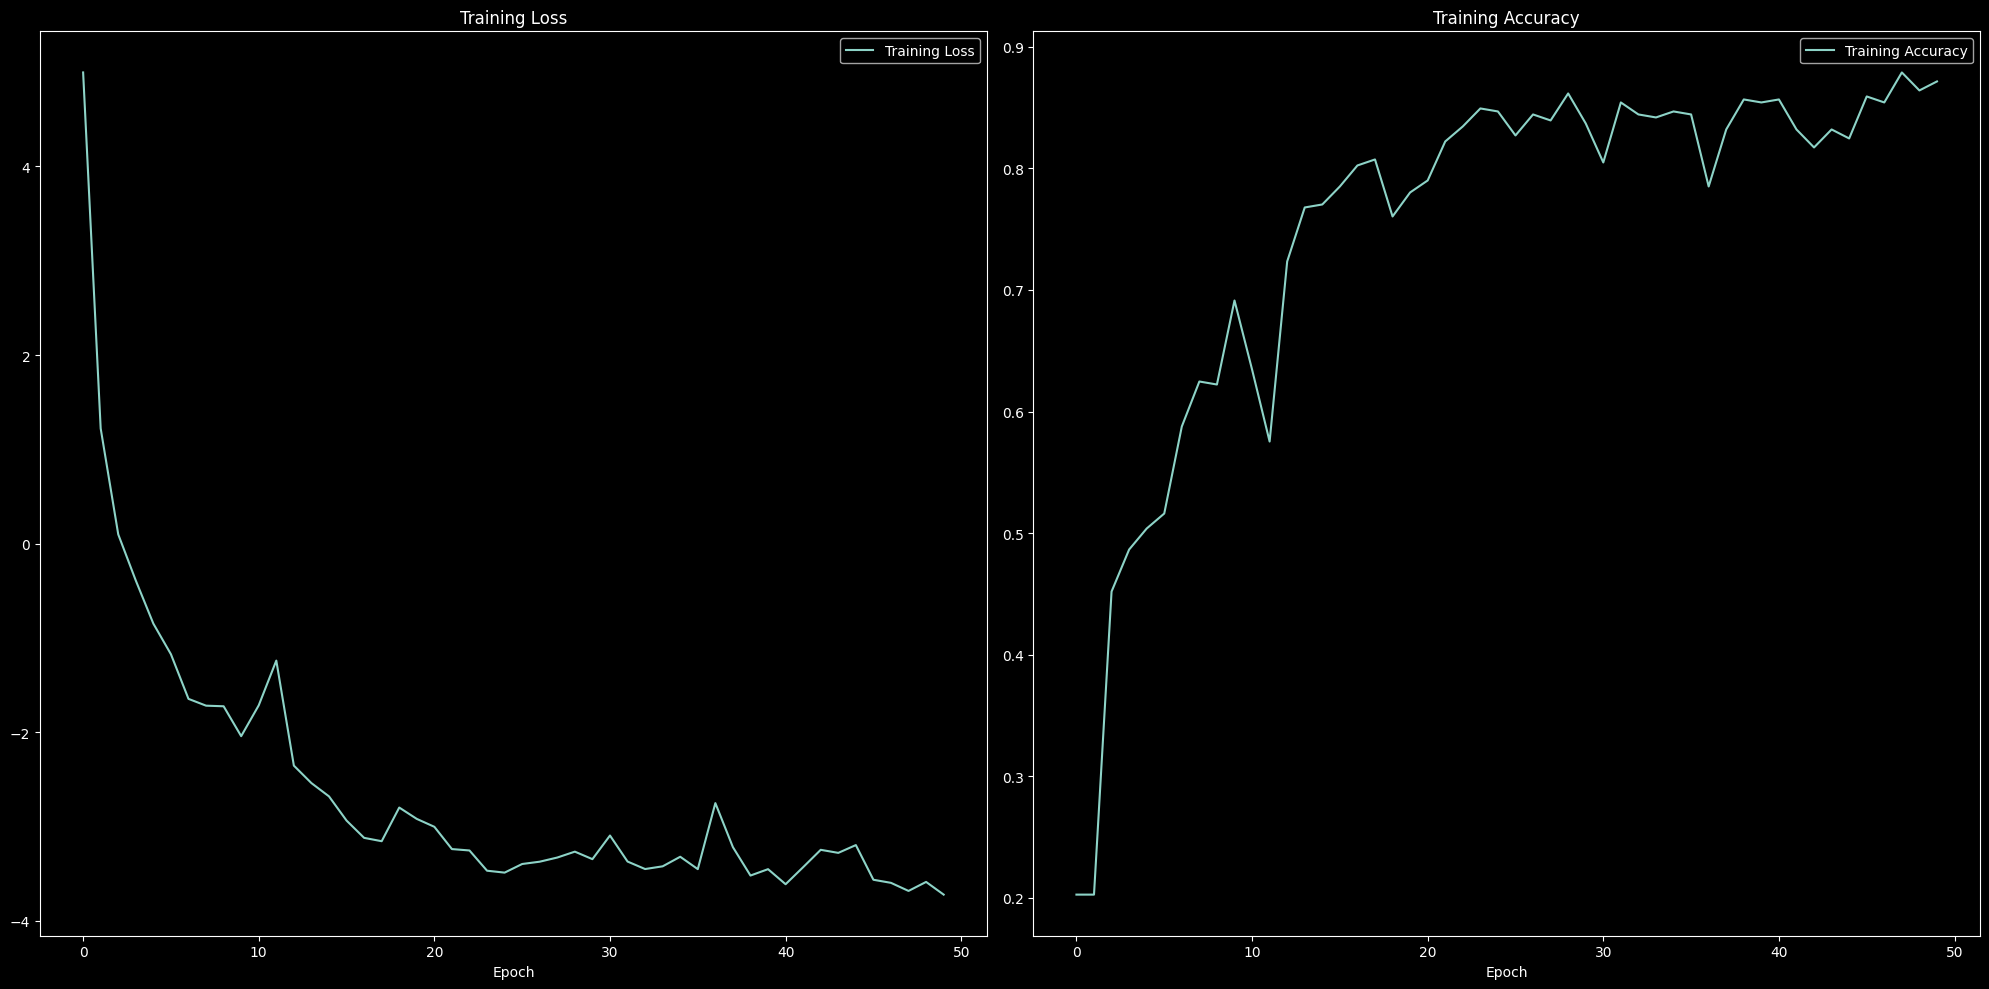

In [73]:
plt.style.use('dark_background')

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
y_p = model.predict(X_test)

2/2 [==============================] - 1s 37ms/step


In [75]:
y_p.shape

(45, 6)

In [76]:
y_test.shape

(45, 6)

In [77]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [78]:
# calculate_reward(y_test,y_p)

In [79]:
res = model.predict(X_test)

2/2 [==============================] - 0s 29ms/step


In [80]:
X_test

array([[[ 0.49618086,  0.46318796, -1.03620827, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49595147,  0.45831627, -1.06946003, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49580893,  0.45694816, -0.96137834, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.52785647,  0.44870579, -0.73364562, ...,  0.19263059,
          0.64495897, -0.05484942],
        [ 0.5304088 ,  0.44674656, -0.71086919, ...,  0.17660128,
          0.66059554, -0.04092993],
        [ 0.53144288,  0.44326001, -0.65259922, ...,  0.17696269,
          0.66063815, -0.03442889]],

       [[ 0.70144379,  0.67719257, -1.85263407, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.69756591,  0.67770112, -1.89853835, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.69698077,  0.68150496, -1.95777678, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6754595 ,  0.67292309, -1.80572736, ...,  

In [81]:
res

array([[1.25264152e-04, 1.89241905e-06, 2.97267216e-05, 9.99839425e-01,
        2.95883456e-06, 7.20621642e-07],
       [3.08570365e-04, 1.01955608e-04, 9.98647869e-01, 6.73639704e-04,
        6.00681087e-05, 2.07902573e-04],
       [5.19996649e-03, 1.21686177e-03, 8.48229468e-01, 4.83490480e-03,
        1.15628878e-03, 1.39362499e-01],
       [3.59752774e-02, 2.15570326e-04, 7.78724432e-01, 4.79718810e-03,
        8.61212960e-04, 1.79426312e-01],
       [1.33482026e-04, 9.81365919e-01, 2.63321672e-05, 2.24314153e-05,
        1.58299934e-02, 2.62177549e-03],
       [9.99988079e-01, 4.54986404e-09, 6.78536799e-06, 5.01625527e-06,
        1.32924171e-07, 1.48602597e-09],
       [7.91911370e-05, 9.65481460e-01, 8.68705320e-06, 1.21406483e-05,
        3.41394469e-02, 2.79011583e-04],
       [9.99995828e-01, 2.27547245e-10, 3.58769535e-06, 6.00014857e-07,
        1.18878187e-08, 7.14257820e-11],
       [2.49190234e-05, 5.50421178e-01, 7.29070916e-06, 2.09296577e-05,
        4.43050265e-01, 

In [82]:
actions[np.argmax(res[6])]

'fear'

In [83]:
actions[np.argmax(y_test[6])]

'fear'

In [ ]:
model.save('action_with_Reward_5_v3.h5')
model.save_weights('action_with_Reward_5_weights_v3.h5')

In [29]:
import tensorflow as tf

In [30]:
model = tf.keras.models.load_model("action_with_Reward_5_v3.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [ ]:
_, test1, _, test1_label = train_test_split(X, y, test_size=0.50)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(test1)

In [ ]:
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [115]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(ytrue,yhat))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        29
           1       0.69      0.58      0.63        19
           2       1.00      0.96      0.98        26
           3       0.94      1.00      0.97        17
           4       0.71      0.77      0.74        22
           5       0.88      1.00      0.94        22

    accuracy                           0.88       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.88      0.88      0.88       135



In [116]:
for num, prob in enumerate(res):
    print(num,prob)

0 [1.2526415e-04 1.8924190e-06 2.9726722e-05 9.9983943e-01 2.9588346e-06
 7.2062164e-07]
1 [3.0857036e-04 1.0195561e-04 9.9864787e-01 6.7363970e-04 6.0068109e-05
 2.0790257e-04]
2 [0.00519997 0.00121686 0.84822947 0.0048349  0.00115629 0.1393625 ]
3 [3.5975277e-02 2.1557033e-04 7.7872443e-01 4.7971881e-03 8.6121296e-04
 1.7942631e-01]
4 [1.3348203e-04 9.8136592e-01 2.6332167e-05 2.2431415e-05 1.5829993e-02
 2.6217755e-03]
5 [9.9998808e-01 4.5498640e-09 6.7853680e-06 5.0162553e-06 1.3292417e-07
 1.4860260e-09]
6 [7.9191137e-05 9.6548146e-01 8.6870532e-06 1.2140648e-05 3.4139447e-02
 2.7901158e-04]
7 [9.9999583e-01 2.2754724e-10 3.5876953e-06 6.0001486e-07 1.1887819e-08
 7.1425782e-11]
8 [2.4919023e-05 5.5042118e-01 7.2907092e-06 2.0929658e-05 4.4305027e-01
 6.4753983e-03]
9 [1.8475046e-07 8.4610501e-06 4.1323199e-07 1.1676671e-07 2.9468763e-06
 9.9998784e-01]
10 [9.9991119e-01 2.1017078e-07 8.0860164e-06 7.6980876e-05 3.4425561e-06
 4.2981625e-08]
11 [0.7844035  0.05776734 0.03967339 0.

In [31]:
from scipy import stats

In [32]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        probability_text = f"{prob * 100:.4f}"  # Format probability to display up to 4 decimal points
        label_text = actions[num]
        cv2.putText(output_frame, f"{label_text}: {probability_text}", (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [119]:
# prob_viz(res[0], actions, image, colors)

In [120]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [33]:
import tensorflow as tf

In [34]:
model = tf.keras.models.load_model("action_with_Reward_5_v3.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [124]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("../../happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

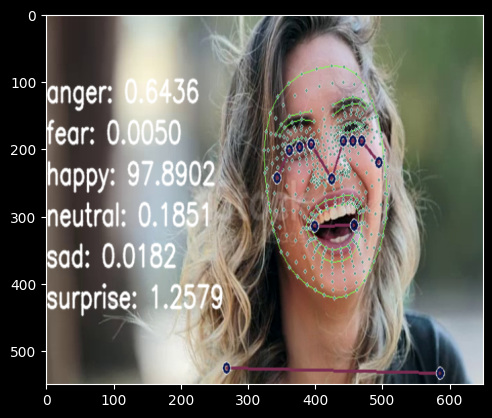

In [125]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [126]:
# history

In [127]:
res

array([6.4355959e-03, 5.0371149e-05, 9.7890204e-01, 1.8506635e-03,
       1.8241978e-04, 1.2578907e-02], dtype=float32)

In [128]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.006435596
fear ----> 5.037115e-05
happy ----> 0.97890204
neutral ----> 0.0018506635
sad ----> 0.00018241978
surprise ----> 0.012578907


In [129]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 2 elements:", top_indices)

Indices of the top 2 elements: [2 5]


In [130]:
ans=[]

In [131]:
for i in top_indices:
    ans.append(actions[i])

In [132]:
ans

['happy', 'surprise']

In [54]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/Body movement data/armflapping-20230830T060845Z-001/armflapping/AMF0.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        brightness_increase = 20  # You can adjust this value as needed
        brightened_image = cv2.add(frame, brightness_increase)

        #Sharp
        kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])
        frame = cv2.filter2D(brightened_image, -1, kernel)

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(res)
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # image = prob_viz(res, actions, image, colors)
        
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [58]:
res

array([5.1054126e-03, 2.4660031e-04, 9.8551404e-01, 8.1558973e-03,
       4.4863444e-04, 5.2945683e-04], dtype=float32)

In [59]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 0.005105412565171719
fear ----> 0.0002466003061272204
happy ----> 0.9855140447616577
neutral ----> 0.00815589725971222
sad ----> 0.0004486344405449927
surprise ----> 0.0005294568254612386


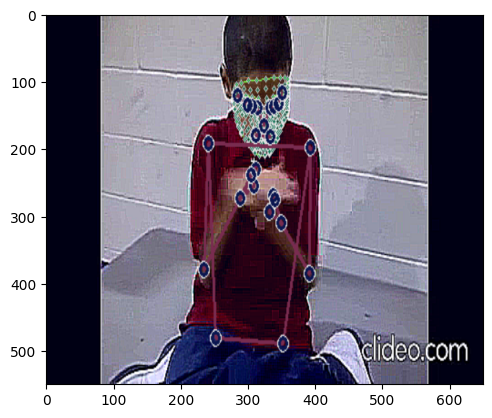

In [60]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [61]:
# J:/AUTISM DETECTION PROJECT/Body movement data/armflapping-20230830T060845Z-001/armflapping/AMF0.mp4

In [62]:
predictions

[array([0.04658631, 0.00998898, 0.48157114, 0.44835824, 0.00777623,
        0.0057191 ], dtype=float32),
 array([0.04147416, 0.00811511, 0.5605961 , 0.37820902, 0.00654056,
        0.00506505], dtype=float32),
 array([0.04075264, 0.00762168, 0.6454357 , 0.2948127 , 0.00630254,
        0.00507472], dtype=float32),
 array([0.04284453, 0.00758179, 0.7098776 , 0.22802283, 0.00648756,
        0.00518564], dtype=float32),
 array([0.04387486, 0.00715255, 0.7446366 , 0.19297202, 0.00637255,
        0.00499151], dtype=float32),
 array([0.0444155 , 0.00695547, 0.7759187 , 0.16130017, 0.00638767,
        0.00502235], dtype=float32),
 array([0.04020466, 0.00620789, 0.8138257 , 0.12914209, 0.00578415,
        0.00483557], dtype=float32),
 array([0.03533887, 0.00483774, 0.84164494, 0.10940136, 0.00468695,
        0.00409005], dtype=float32),
 array([0.03003359, 0.00365832, 0.8687148 , 0.090514  , 0.00373449,
        0.00334485], dtype=float32),
 array([0.02463705, 0.00276089, 0.8976479 , 0.06922959,

In [63]:
answerArr=[]

cnt=1
for i in predictions:
    if(cnt%2==0):
        ind=np.argsort(i)[-2:][::-1]
        temp={'frame':cnt-1,actions[0]:i[0],actions[1]:i[1],actions[2]:i[2],actions[3]:i[3],actions[4]:i[4],actions[5]:i[5],'MAX1':actions[ind[0]],'MAX2':actions[ind[1]]}
        answerArr.append(temp)
    cnt+=1

In [64]:
answerArr

[{'frame': 1,
  'anger': 0.041474164,
  'fear': 0.008115111,
  'happy': 0.5605961,
  'neutral': 0.37820902,
  'sad': 0.0065405574,
  'surprise': 0.0050650514,
  'MAX1': 'happy',
  'MAX2': 'neutral'},
 {'frame': 3,
  'anger': 0.04284453,
  'fear': 0.0075817932,
  'happy': 0.7098776,
  'neutral': 0.22802283,
  'sad': 0.006487559,
  'surprise': 0.005185644,
  'MAX1': 'happy',
  'MAX2': 'neutral'},
 {'frame': 5,
  'anger': 0.044415496,
  'fear': 0.0069554723,
  'happy': 0.7759187,
  'neutral': 0.16130017,
  'sad': 0.0063876724,
  'surprise': 0.005022346,
  'MAX1': 'happy',
  'MAX2': 'neutral'},
 {'frame': 7,
  'anger': 0.035338867,
  'fear': 0.004837744,
  'happy': 0.84164494,
  'neutral': 0.10940136,
  'sad': 0.004686946,
  'surprise': 0.0040900507,
  'MAX1': 'happy',
  'MAX2': 'neutral'},
 {'frame': 9,
  'anger': 0.024637045,
  'fear': 0.0027608909,
  'happy': 0.8976479,
  'neutral': 0.06922959,
  'sad': 0.0029386391,
  'surprise': 0.0027858652,
  'MAX1': 'happy',
  'MAX2': 'neutral'},
 

In [65]:
import pandas as pd
pd.DataFrame(answerArr)

,frame,anger,fear,happy,neutral,sad,surprise,MAX1,MAX2
0,1,0.041474,0.008115,0.560596,0.378209,0.006541,0.005065,happy,neutral
1,3,0.042845,0.007582,0.709878,0.228023,0.006488,0.005186,happy,neutral
2,5,0.044415,0.006955,0.775919,0.161300,0.006388,0.005022,happy,neutral
3,7,0.035339,0.004838,0.841645,0.109401,0.004687,0.004090,happy,neutral
4,9,0.024637,0.002761,0.897648,0.069230,0.002939,0.002786,happy,neutral
5,11,0.017624,0.001512,0.937569,0.039794,0.001752,0.001751,happy,neutral
6,13,0.013091,0.001008,0.960224,0.022941,0.001334,0.001402,happy,neutral
7,15,0.009323,0.000429,0.972836,0.015998,0.000687,0.000727,happy,neutral
8,17,0.005105,0.000247,0.985514,0.008156,0.000449,0.000529,happy,neutral
